** chapter 02 End-to-End Machine Learning Project **

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.isdir(IMAGES_PATH):
        os.makedirs(IMAGES_PATH)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Get the data

本章中的数据集为 StatLib  的加州房产价格，是基于1990年加州普查的数据。
数据包含每个街区组的人口、收入中位数、房价中位数等。

本章的任务是利用该数据集，建立一个加州房价模型，然后利用这个模型来预测任何其他街区的房价中位数。

In [3]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
# execute once！
# fetch_housing_data()

## 现对数据有个初步认识

In [5]:
datapath = os.path.join("datasets", "housing", "")
housing = pd.read_csv(datapath + "housing.csv")
housing.head() # first 5 rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


可以看到每个数据有10个属性值：经度、纬度、房龄中位数、总房间数、总我市数、人口数、家庭数、收入中位数、房价中位数以及离海距离。

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


数据集中共有20640个实例，我们注意到总房间数这一项只有20433个非空置，这意味着有207个街区缺少该项属性值，后面我们需要对其进行处理。

从上面我们可以注意到“离大海距离”这一项不是数值，而是表示某项属性的字段，那么我们可以使用`value_counts()`方法查看该项中有哪些类别：

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe() # 显示数值类属性的概括

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


`count`、`mean`、`std`、`min`和`max`都很好理解，需要注意的就是计算这些值时，是忽略空值的。
百分数指的是小于该值的百分比。例如：25%的房子年龄中位数小于18

另一种快速了解数据的方法是画出每类数据的柱状图。

Saving figure attribute_histogram_plots


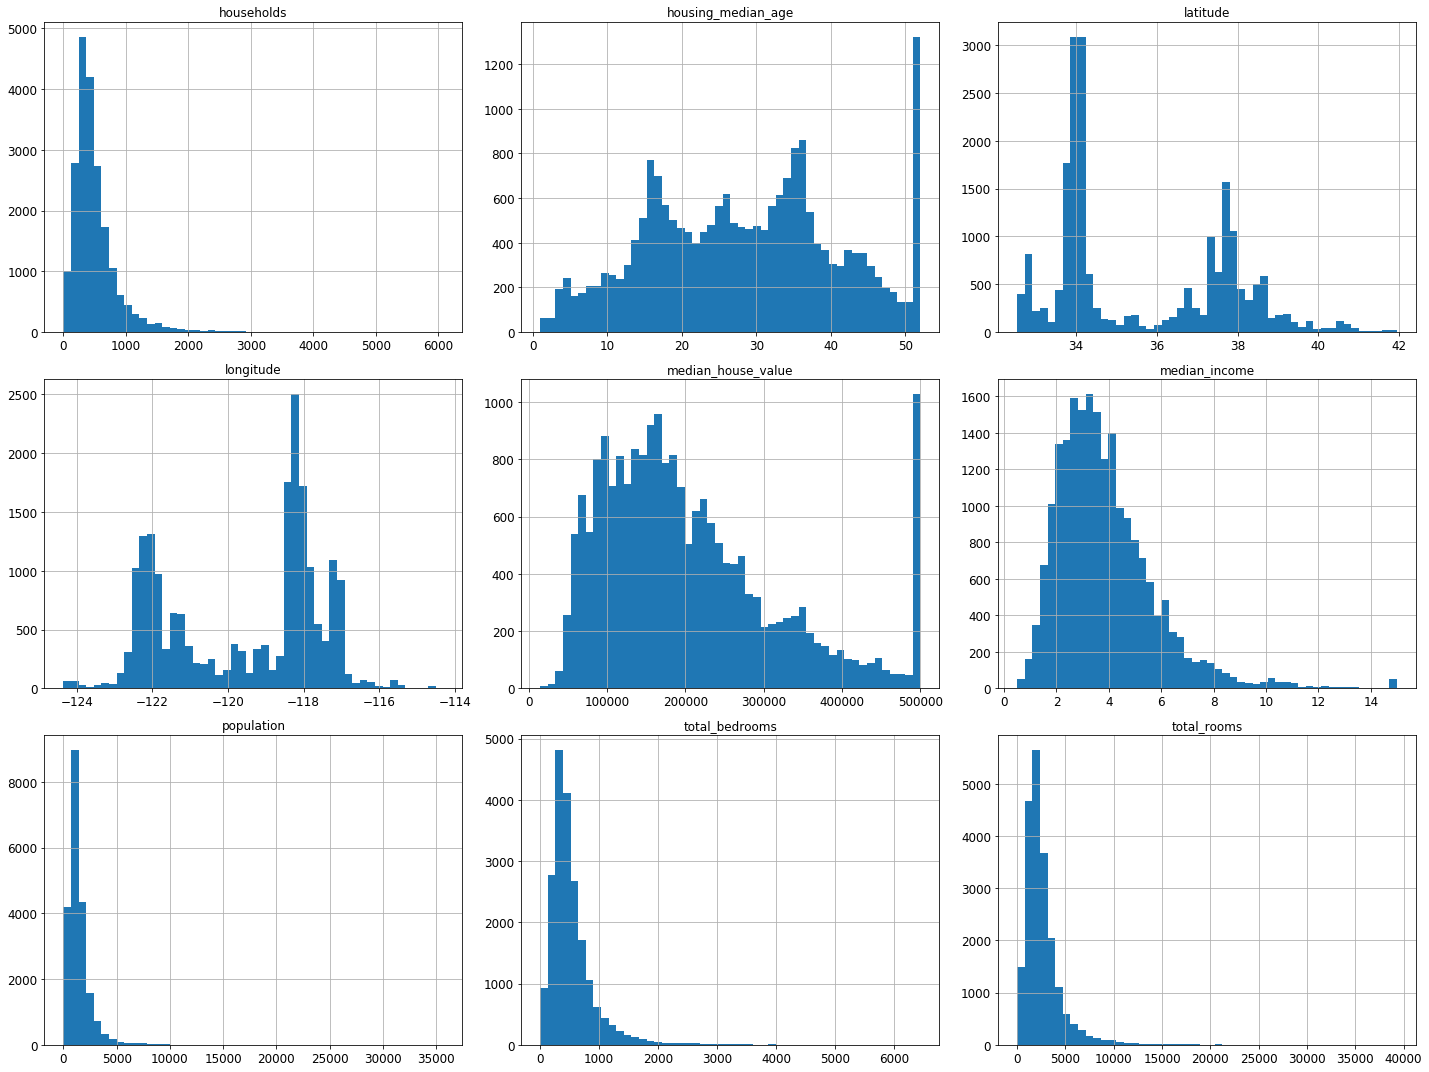

In [9]:
housing.hist(bins=50, figsize=(20, 15))
save_fig("attribute_histogram_plots")
plt.show()

注意到柱状图中的一些特点：
1. 首先，收入中位数不是以美元（USD）为单位，可知数据是家冷啊缩放调整的，过高收入会变成15（实际为15.0001），过低的会变为5（实际为0.499）。在机器学习中对数据进行了预处理很正常，但是我们要知道数据是如何进行处理的。

2. 房屋年龄中位数和房屋价值中位数也都设了上限，对于后者可能是个严重的问题，因为这是我们的目标属性（label）。这样学习得到的模型预测的值可能不会超过这个上限。若需要明确的预测值，那么即使超过500000美元，我们可以有两个选项：
    - 对于设定了上限的数据，重新收集合适的标签
    - 将这些街区的数据从数据集（训练集和测试集）中移除
    
3. 属性具有不同的度量。这涉及到特征缩放的问题。

4. 最后，许多柱状图的尾巴过长，对于机器学习的假设而言，会使检测规律变得更难。我们会尝试变换处理这些属性，使其变为正态分布。

## 创建测试集

在进一步查看数据之前，我们需要将测试集分割出来，这是因为我们的大脑是一个善于发现规律的系统，如果提前查看了测试集，就会不经意的按照测试集中规律来选择某个特定的机器学习模型，当你使用测试集来评估模型时，就会使结果过于乐观，而实际部署的系统表现就会差，这称为数据透视偏差。

理论上，创建测试集只需要随机挑选一些实例，为整个数据集的20%。

In [10]:
np.random.seed(2018)

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


若不设定固定的随机数种子，那么每次就会产生不同的测试集，多次运行之后，你可能就会得到整个数据集，这是需要避免的。

解决方法之一就是设定固定的随机数种子，以产生相同的洗牌指数（shuffled indices）。

但若数据集更新了，该方法就会失效。一种通常的解决办法就是使用每个实例的ID（每个实例ID固定且唯一）来判断该实例是否应该放入测试集中。
例如：可以计算出每个实例ID的哈希值，只保留其最后一个字节，若该字节小于51（约为256的20%），就将其放入测试集中，这样可以保证在多次运行中测试集保持不变，即使更新了数据集，新的测试集中会包含新实例中的20%，但不会有之前位于测试集中的实例

In [12]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
# 使用行索引作为ID
housing_with_id = housing.reset_index() # add an "index" column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

这里使用行索引作为唯一识别码，那么需要保证新数据置于现有数据的尾部，且没有行被删除。若做不到，则可以使用最稳定的特征来创建唯一识别码，例如街区的经度和纬度在几百万年内基本是不会改变的，所以可以将两者结合成一个ID

In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

`scikit-learn` 提供了一些函数，可以用多种方式将数据集分割为多个子集。最简单的函数是 `train_test_split`，它的作用和之前的函数 `split_train_test`很像，并带有其他的一些功能。首先，其`random_state`参数可以设定随机数种子；第二，可以将种子函数传递给多个行数相同的数据集，可以在相同的索引上分割数据集。这个功能非常有用，当你的标签值放在另一个`DataFrame`中的时候。

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=2018)

目前为止，我们采用的都是纯随机的取样方法。当数据集很大时（尤其是和属性数相比），这通常的是可行的。但若数据集不大，就会有采样偏差的风险。

假设专家告诉你，收入中位数是预测房价中位数非常重要的属性。那么你的测试集可能需要包含代表整体数据集中的多种收入分类。但收入中位数是一个连续的数值属性，因此，首先需要创建一个收入类别属性。再仔细的看一下收入中位数的柱状图：

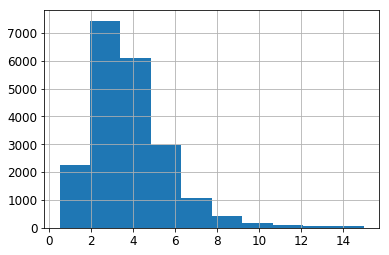

In [16]:
housing["median_income"].hist()
plt.show()

大多数的收入中位数在2～5万美元之间，但有一些收入中位数超过了6。我们要保证每个分层都要有足够的实例位于数据之中，否则对分层重要性的评估就会有偏差。这意味着不能有过多的分层，且每个分层要足够大。这里通过将中位数除以1.5来创建一个收入类别属性，用 `ceil` 对值舍入以产生离散的分类，然后将所有大于5的分类归入到分类5

In [17]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

现在就可以更具收入进行分类，即分层采样。可以使用scikit-learn中的`StratifiedShuffleSplit`类

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2018)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

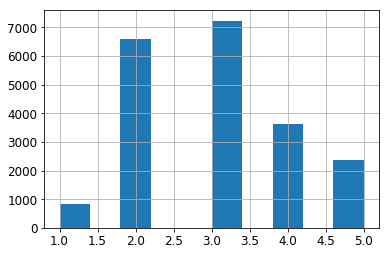

In [19]:
housing["income_cat"].hist()

现在可以在完整的房产数据集中查看收入分类的比例：

In [20]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [21]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

可以看到，测试集中的收入分类比例与整个数据集的比例是一样的

In [22]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=2018)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set)
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100



In [23]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.038033,-4.501217,-0.243309
2.0,0.318847,0.318798,0.324612,1.808236,-0.015195
3.0,0.350581,0.350533,0.338905,-3.330569,-0.013820
4.0,0.176308,0.176357,0.182171,3.325089,0.027480
5.0,0.114438,0.114583,0.116279,1.608806,0.127011


上表中对比了总数据集、分层采样的测试集、纯随机采样测试集的收入分类比例。可以看到分层采样测试集的收入分类比例几乎与总数据集相同，而随机采样测试集偏差严重。

现在我们删除 `income_cat` 属性，使数据回到初始状态：

In [24]:
for s in (strat_train_set, strat_test_set):
    s.drop(["income_cat"], axis=1, inplace=True)

测试集的生成是机器学习过程从十分重要的一部分，生成测试集的过程对于后面的交叉验证十分有帮助。

## 数据可视化

目前，我们知识快速查看了数据，对要处理的数据有了整体了解，现在的目标是更深入的探索数据。

首先，将测试集放在一边，只对训练集进行探索。若训练集很大，我们就需要再采样出来一个探索集，保证操作方便快捷。在这个案例中，训练集很小，我们可以在全集上直接工作。这里现创建一个副本，以免损伤训练集

In [25]:
housing = strat_train_set.copy()

### 地理数据可视化

数据中存在经纬度，所以将数据以地理坐标的形式进行可视化是不错的选择

Saving figure housing_prices_scatterplot


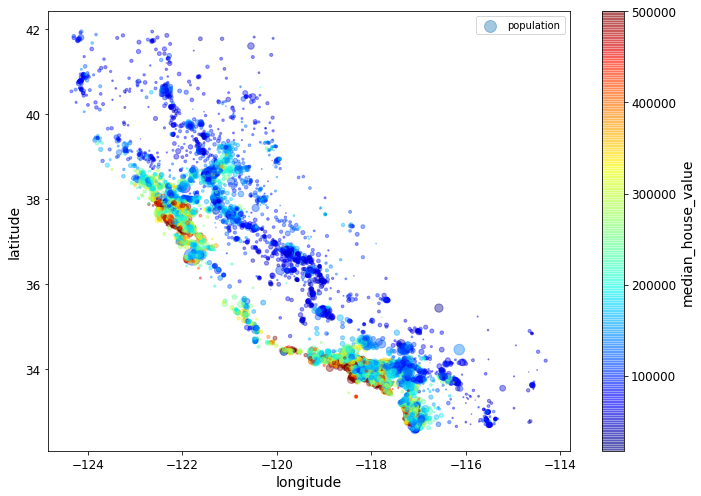

In [26]:
import matplotlib.image as mpimg


housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10, 7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")
plt.show()

Saving figure california_housing_prices_plot


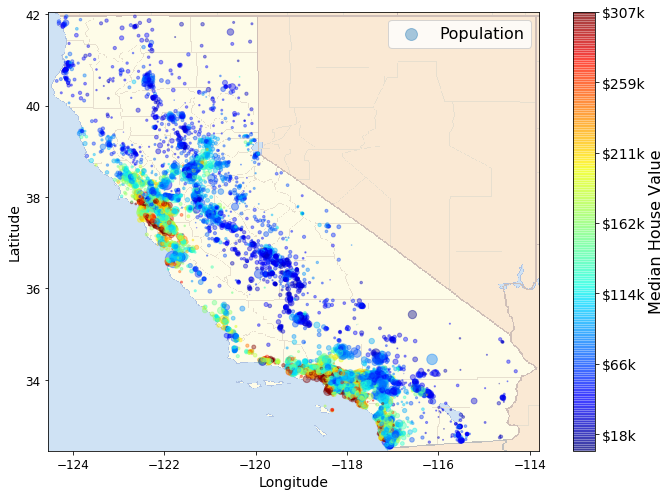

In [27]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

图中每个圈的半径表示街区人口（选项`s`）,颜色代表价格（选项`c`）。

可以看出房价与位置以及人口密度关系密切。

### 查找关联

因为数据集不大，可以非常方便的使用`corr()` 方法计算出没对属性间的标准相关系数：

In [28]:
corr_mtx = housing.corr()

In [29]:
corr_mtx["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691643
total_rooms           0.133672
housing_median_age    0.106523
households            0.067060
total_bedrooms        0.049535
population           -0.020910
longitude            -0.051276
latitude             -0.140561
Name: median_house_value, dtype: float64

相关系数的范围是-1到1.接近1时意味着正相关；

另一种检测属性间相关系数的方法时利用Pandas中的`scatter_matrix`函数，其能画出每个数值属性对其他数值属性的图。由于共有11个数值属性，会产生121幅图，这里只对特定的4个属性就行作图

Saving figure scatter_matrix_plot


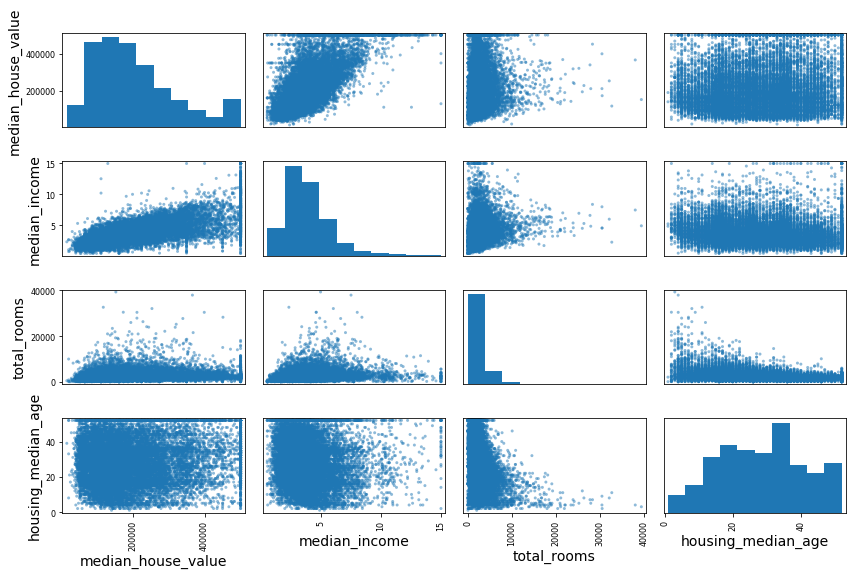

In [30]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

若每个变量对自己作相关图，主对角将会是一条线，所以pandas里用每个属性的柱状图代替了。

现将收入中位数与房价中位数的关系放大（直觉上，收入中位数与房价的关系最大）：

Saving figure income_vs_house_value_scatterplot


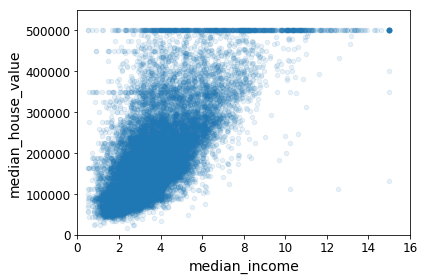

In [31]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

可以看到，相关性非常高。随着收入的增加，房价也随之升高。

此外，之前看到的最高价，清晰地呈现为一条位于50000美元的直线。除此之外，在45000、35000以及28000左右的位置都呈现出了直线。这些直线可以看作是巧合，在进行进一步处理前，我们希望从数据集中去除巧合，以防算法将巧合作为数据规律。

### 属性组合实验

在前面的一节中，我们探索数据发现了属性间的一些关联以及巧合，在给算法提供数据前，需要将巧合去除。另外，一些属性具有长尾分布，可能需要对其进行转换（如：计算其log对数）。

在给算法准备数据之前，需要做的最后一件事是尝试多种属性的组合。例如，如果你不知道某个街区有多少户，那么知道该街区的总房间数也就没什么用。你真正需要的是每户有多少个房间。类似的，总卧室数也不重要：你可能需要将其与房间数进行比较。每户的人口数也是一个重要的属性。现在我们来创建这些新的属性：

In [32]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [33]:
# 相关矩阵
corr_mtx = housing.corr()
corr_mtx["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.691643
rooms_per_household         0.146850
total_rooms                 0.133672
housing_median_age          0.106523
households                  0.067060
total_bedrooms              0.049535
population                 -0.020910
population_per_household   -0.032251
longitude                  -0.051276
latitude                   -0.140561
bedrooms_per_room          -0.256945
Name: median_house_value, dtype: float64

与总房间数或卧室数相比，新的属性`bedrooms_per_room`与房价中位数的相关性更强。显然，房间中卧室的比率越低，房价越高。属性`rooms_per_household`也比街区的总房间数这一属性包含更多的信息：房间越多，房屋越大，房价就越高。

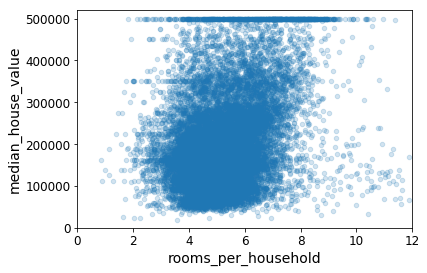

In [34]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
            alpha=0.2)
plt.axis([0, 12, 0, 520000])
plt.show()

## 为机器学习算法准备数据

为了保证数据处理的通用性，你需要编写一些函数：

- 函数可以让你在任何数据集上方便的进行数据转换
- 可以慢慢积累为一个转换函数库，在以后的项目中复用
- 可以方便的尝试多种数据转换，查看哪些数据转换结合起来效果最好

在此之前，我们回到干净的训练集

In [35]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### 数据清洗

大多数的机器学习算法不能处理缺失的特征属性，因此需要现对数据集中的缺失数据进行处理。前面在对数据初步认识过程中，我们注意到属性`total_bedrooms`有一些缺失值，现在有3中解决方案：

- 去掉对应的街区

- 去掉整个属性

- 对缺失值进行填充（0、均值、中位数等）

用`DataFrame`的`dropna()`,`drop()`和`fillna()`方法，可以方便的实现上述三种方案：

In [36]:
housing.dropna(subset=["total_bedrooms"])
housing.drop("total_bedrooms", axis=1)
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)

969       471.0
6669      459.0
1        1106.0
16519      84.0
13900    2634.0
7214      219.0
17746     415.0
11258    1081.0
17157     134.0
7530      200.0
13163     782.0
19014      35.0
13053    1819.0
281       336.0
13972    1985.0
537       368.0
15954     506.0
7329      177.0
17757     415.0
13335     374.0
6295      472.0
6013      491.0
5844     1985.0
4246      416.0
2356      353.0
8949      502.0
19911     308.0
20226     932.0
17859     513.0
3120      316.0
          ...  
5158      304.0
14564     544.0
7314      556.0
4746      419.0
6518     1485.0
20040     165.0
4087      909.0
3237       78.0
6651      407.0
12450     174.0
14925     380.0
10221     626.0
9234      253.0
9788      162.0
17453     383.0
616       223.0
14534     463.0
4082      546.0
17572     254.0
6694      549.0
20201     411.0
7248      332.0
10161     347.0
1096      422.0
6112      391.0
8401      410.0
18565     589.0
15083    1152.0
14570     501.0
7435      271.0
Name: total_bedrooms, Le

 `scikit-learn`提供了一个方便的类来处理缺失值：`Imputer`。
 
 首先创建一个`Imputer`实例，指定用某属性的中位数来代替该属性中的缺失值

In [37]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

/Users/pzhang/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


因为只有数值属性才能计算中位数，我们需要创建一份不包括`ocean_proximity`属性的数据副本

In [38]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [39]:
# 将数据传递给 imputer.fit() 方法
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

imputer 计算出每个属性的中位数，并将结果保存在实例变量`statistics_`中。虽然此时只有属性`total_bedrooms`存在缺失值，但我们不能确定在以后的新的数据中会不会有其他属性出现缺失值，所以安全的做法是将`imputer`应用到每个数值属性：

In [40]:
imputer.statistics_

array([-118.49  ,   34.26  ,   29.    , 2127.    ,  435.    , 1166.    ,
        410.    ,    3.5333])

In [41]:
housing_num.median().values

array([-118.49  ,   34.26  ,   29.    , 2127.    ,  435.    , 1166.    ,
        410.    ,    3.5333])

现在，可以使用这个填充过的`imputer`来对训练集进行转换，将缺失值替换为中位数：

In [42]:
X = imputer.transform(housing_num)

这里返回的结果`X`是一个包含转换后特征的普通`NumPy`数组，如果将其放到Pandas的`DataFrame`中，也很简单：

In [43]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### 处理文本和类别属性

因为`ocean_proximity`是文本属性，无法计算中位数，所在在前面的处理中我们将其丢弃了。大多数的机器学习算法是和数字打交道的，所以需要将这些文本标签转换为数字。

`scikit-learn`为这个任务提供了一个转换器`LabelEncoder`:

In [44]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)

housing_cat_encoded

array([1, 1, 3, ..., 0, 4, 0])

编码器是通过属性`classes_`来学习的。
`<1H OCEAN` 被映射为0，`INLAND` 被映射为1

In [45]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


这种编码方式的问题是，ML算法后认为两个相邻的值更相似，这样显然不对（例如，分类0和4比0和1更相似）。

要解决这个问题，常用的方法是给每个分类创建一个二元属性。称为One-hot编码

In [46]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories="auto")
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

输出是一个`SciPy`稀疏矩阵，而不是NumPy数组。当类别属性有很多歌分类时，这样非常有用。经过one-hot编码后，得到的矩阵每行只有一个1，其余都为0，因此使用稀疏矩阵进行存储。当然，也可使使用`toarray()`方法将其转换为普通NumPy数组：

In [47]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

要一步完成这两个转换，可以使用`LabelBinarizer`类

In [48]:
from sklearn.preprocessing import LabelBinarizer

cat_encoder = LabelBinarizer()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)

housing_cat_1hot

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]])

返回的默认是一个稠密NumPy数组，向构造器`LabelBinarizer`传入`sparse_output=True`即可得到稀疏矩阵。

### 自定义转换器

尽管scikit-learn提供了许多有用的转换器，有时候还是需要手动写转换器，比如自定义的清理操作或属性操作等。需要将自定义的转换器与scikit-learn组建无缝衔接工资，你需要创建一个类，并执行三个方法：`fit()`（返回self），`transform()` 和 `fit_transform()`。

通过添加`TransformerMixin` 作为基类，可以很容易的得到最后一个。如果你添加了`BaseEstimator`作为基类（且构造器中避免使用`*args`和`**kargs`），可以得到两个额外的方法`get_params()` 和`set_params()`，二者可以方便的对超参数进行微调

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombineAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                        bedrooms_per_room]
        else:
            return np_c[X, rooms_per_household, population_per_household]
        
attr_adder = CombineAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.transform(housing.values)

在这个例子中，转换器有一个超参数 `add_bedrooms_per_room` ，默认设为 `True` （提供一个合 理的默认值很有帮助）。这个超参数可以让你方便地发现添加了这个属性是否对机器学习算法有帮助。更一般地，你可以为每个不能完全确保的数据准备步骤添加一个超参数。数据准 备步骤越自动化，可以自动化的操作组合就越多，越容易发现更好用的组合（并能节省大量时间）。

### 特征缩放

数据要做的最重要的转换之一是特征缩放。一般而言，当输入的数值属性的量度不同时，机器学习算法的性能不会太好。这个规律也适用于房产数据：总房间数分布范围是6到39320，而收入中位数只分布在0到15。

需要注意的是，不要对目标值进行了缩放！

有两种常见的方法可以让所有的属性具有相同的度量：

- 线性归一化（Min-Max Scaling）
- 标准化(Standardlization)

线性函数归一化，也称为归一化（normalization）很简单：值被转换、重新缩放，直到范围变为0到1。通过减去最小值，然后除以最大最小值之间的差来进行归一化。`scikit-learn`提供了一个转换器`MinMaxScaler` 来实现这一功能，它有一个超参数`feature_range`，可以让你改变归一化范围。

标准化计算过程：减去均值，然后除以方差，使得到的分布具有单位方差。与归一化不同，标准化不会限定值在某一固定范围，但对某些算法可能是个问题，例如神经网络常需要输入值在0到1之间。但是标准化受异常值的影响很小。`scikit-learn`提供了一个转换器`StandardScaler`来进行了标准化。

### 转换管道 （Transformation Pipelines）

在数据处理中，存在许多数据需要转换，需要按照一定的顺序进行。`scikit-learn`提供了类`Pipeline`来进行了这一系列的转换

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombineAttributesAdder()),
    ("std_scaler", StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

`Pipeline` 构造器需要定义步骤顺序的名字的列表，除了最后一个估计器，其余都是转换器（要有`fit_transform()`方法）。

当调用管道的`fit()`方法时，就会对所有的转换器依次调用 `fit_transform()`，将每次调用的输出作为下一个转换器的输入，一直到最后的估计器，它只调用`fit()`方法。

在上面的例子中，最后的估计器是`StandardScaler`，它是一个转换器，因此这个管道有一个`transform()`方法，可以顺序对数据进行转换。

上述是针对数值属性的管道流水线。那么对于分类属性怎么将其转换为管道流水线呢？`scikit-learn` 提供了一个`FeatureUnion` 来实现这一功能。

In [51]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [52]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombineAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

In [53]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

可以很简单的运行这个流水线：

In [54]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15875827,  0.95428517, -0.69249925, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72766542, -0.688506  ,  1.85418832, ...,  0.        ,
         0.        ,  0.        ],
       [-1.32344606,  1.04321119, -0.61291526, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.30157739, -1.32502907, -0.77208323, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17681392, -1.31098812,  0.50126055, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.68774111, -0.78679265,  1.21751643, ...,  0.        ,
         0.        ,  0.        ]])

实际上，从`scikit-learn` 0.20 版本开始，利用 `ColumnTransformer` 可以更好地完成这类任务：

In [55]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

new_full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs), # 数值类属性
    ('cat', OneHotEncoder(), cat_attribs), # 类别属性
])

new_housing_prepared = new_full_pipeline.fit_transform(housing)
new_housing_prepared

array([[-1.15875827,  0.95428517, -0.69249925, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72766542, -0.688506  ,  1.85418832, ...,  0.        ,
         0.        ,  0.        ],
       [-1.32344606,  1.04321119, -0.61291526, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.30157739, -1.32502907, -0.77208323, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17681392, -1.31098812,  0.50126055, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.68774111, -0.78679265,  1.21751643, ...,  0.        ,
         0.        ,  0.        ]])

In [56]:
np.allclose(housing_prepared, new_housing_prepared)

True

可以看到结果和前面利用`FeatureUnion`得到的完全一样。

## 选择和训练模型

可算到这一步了！前面我们在问题定位，数据获取，尤其是数据准备和清洗上花费了大量的工作，这一切都是为了利用ML算法来训练模型作准备。

### 在训练集上训练和评估

In [57]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

现在就有了一个可用的线性回归模型，可以用训练集中一些实例来进行验证

In [58]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions\t", lin_reg.predict(some_data_prepared))

Predictions	 [268478.32039884 258639.21943233 434586.07032975  89265.05336872
  91628.93892293]


In [59]:
print("Lables:\t\t", list(some_labels))

Lables:		 [247900.0, 325600.0, 358500.0, 101800.0, 51300.0]


尽管可以预测，但是结果不怎么准确。可以使用`mean_squared_error`函数，用全部训练集来计算这个模型的RMSE

In [60]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

67432.30583287157


虽然结果不太好，但总比没有强。大多数街区的`median_housing_values`在120000到265000美元之间，因此预测误差67432美元不能让人满意。这是一个模型欠拟合的例子，意味着特征没有提供足够多的信息来做一个好的预测，或者模型不够强大。解决欠拟合主要有两个方法：

- 选择更复杂的模型
- 去掉模型上的限制

在线性回归模型中，没有正则化，所以排除第二种选项。可以尝试添加更多特性。在此之前，我们先尝试一个更为复杂的模型来看看效果：

In [61]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [62]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

可以看到，这个模型对训练数据可以完全拟合！但这通常意味着严重的过拟合。要避免此种情况：

1. 正则化
2. 交叉验证

### 利用交叉验证做更佳的评估

交叉验证的思想是利用大部分的训练集来进行训练，余下的一小部分用来验证模型。通常使用的交叉验证方法有：

1. S-fold cross-validtion
2. boostraping

S折交叉验证就是每次将训练集随机的分成S个大小相同的子集，然后选择S-1个子集作为训练集，余下的1个子集作为验证集。

In [65]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [66]:
# 显示结果
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [70564.38284771 70783.86198474 69064.50182465 69291.07142308
 70359.71181748 69494.62386325 65931.48100901 64812.34393899
 71607.28102549 67081.75786453]
Mean: 68899.10175989286
Standard deviation: 2124.613943689646


现在决策树就不像前面看起来那么好了。实际上比线性回归模型还糟。交叉验证不仅可以得到模型性能的评估，还能测量评估的准确性（即它的标准差）。

下面我们用线性回归模型计算其交叉验证的结果：

In [68]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [68088.50380254 68705.92092583 69257.07268988 67269.63514852
 68249.01636742 65997.12297523 68501.8803486  62910.88766225
 68245.48542505 69139.40370576]
Mean: 67636.49290510833
Standard deviation: 1813.3236185762178


比较后发现决策树模型过拟合很严重。它的性能比线性模型还差。

现在再尝试最后一个模型：`RandomForestRegressor`。随机森林是通过用特征的随机子集训练许多决策树。

In [74]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)

print(forest_rmse)

/Users/pzhang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22143.89227787708


In [75]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [52788.65401227 52854.42994412 54656.27720209 52970.5516252
 52557.9146909  51168.60365218 52498.4623593  48818.50308575
 50402.81448634 55460.03590944]
Mean: 52417.62469675786
Standard deviation: 1830.3395020252187


随机森林模型看起来好多了。但是训练集的误差仍然比验证集低得多。解决过拟合可以简化模型，给模型加限制（正则化），或使用更多的训练数据。在深入随机森林之前，我们应该尝试下机器学习的其他类型模型（SVM，神经网络等），不要在调节超参数花费太多时间。目标是列出可能模型的列表。

Tips：要保存每个试验过的模型，以便后续可以再用。要确保有超参数和训练参数， 以及交叉验证评分，和实际的预测值。这可以让你比较不同类型模型的评分，还可以比较误差种类。你可以用 Python 的模块 `pickle` ，非常方便地保存 `Scikit-Learn` 模型，或 使用 `sklearn.externals.joblib` ，后者序列化大 `NumPy` 数组更有效率

``` python
from sklearn,external import joblib

joblib.dump(my_model, "my_model.pkl")

my_model_loaded = joblib.load("my_model.pkl")
```

## 模型微调